In [1]:
# Import all required dependencies
import pandas as pd
import numpy
import matplotlib.pyplot as plt 
import matplotlib.dates as dates
import pandas
import math

from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Activation
from keras.metrics import mse, mae, mape
from keras import backend as K
from keras import optimizers

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [2]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [3]:
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

In [4]:
# Hyperparameter
look_back = 10 # No of prev input used to predict next value
time_steps = 100 # No of time steps future prediction(s)
training_percent = 0.70

In [5]:
# series = pd.read_csv('S&P500.csv', header=0, usecols=[4])
series = pd.read_csv('S&P500.csv')
series['Date'] = pd.to_datetime(series.Date)
series = series.sort('Date')
series = series.reset_index(drop=True)

/Users/user/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [6]:
# Print the first 5 rows
series.head()

,Date,Open,High,Low,Close,Volume,Adjusted Close
0,1950-01-02,17.05,17.05,17.05,17.05,1810000,17.05
1,1950-01-03,17.24,17.24,17.24,17.24,1410000,17.24
2,1950-01-05,18.22,18.22,18.22,18.22,2390000,18.22
3,1950-01-06,18.77,18.77,18.77,18.77,1580000,18.77
4,1950-01-08,18.02,18.02,18.02,18.02,1970000,18.02


In [7]:
# Print the last 5 rows
series.tail()

,Date,Open,High,Low,Close,Volume,Adjusted Close
16136,2014-09-01,1839.00,1843.23,1830.38,1838.13,3581150000,1838.13
16137,2014-10-01,1840.06,1843.15,1832.43,1842.37,3335710000,1842.37
16138,2014-10-02,1796.20,1799.94,1791.83,1799.84,3312160000,1799.84
16139,2014-11-02,1800.45,1823.54,1800.41,1819.75,3699380000,1819.75
16140,2014-12-02,1820.12,1826.55,1815.97,1819.26,3326380000,1819.26


In [8]:
# Only get the Close column
new_df = series.drop('Date', 1)
new_df = new_df.drop('Open', 1)
new_df = new_df.drop('High', 1)
new_df = new_df.drop('Low', 1)
new_df = new_df.drop('Volume', 1)
new_df = new_df.drop('Adjusted Close', 1)

In [9]:
new_df

,Close
0,17.05
1,17.24
2,18.22
3,18.77
4,18.02
5,18.55
6,19.56
7,19.66
8,16.67
9,16.72


<IPython.core.display.Javascript object>


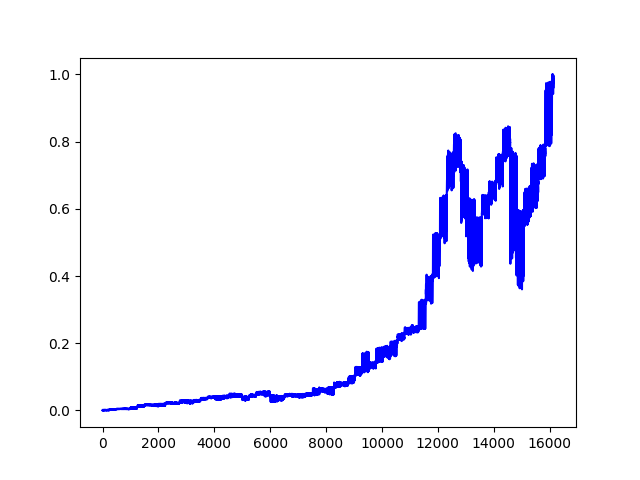

In [10]:
# Plot baseline and predictions
%matplotlib notebook

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
close_dataset_norm = scaler.fit_transform(new_df)

plt.plot(close_dataset_norm, color='b')
plt.show()

In [44]:
# Split into train and test sets (Training: 70%, Test: 30%)
train_size = int(len(close_dataset_norm) * training_percent)
test_size = len(close_dataset_norm) - train_size
train, test = close_dataset_norm[0:train_size,:], close_dataset_norm[train_size:len(close_dataset_norm),:]
print("Training datasets: ", len(train), ", Test datasets: ", len(test))
print("Training sets percentage (%):", float(training_percent)*100, ", Test sets percentage (%):", 100-float(training_percent)*100)

Training datasets:  11298 , Test datasets:  4843
Training sets percentage (%): 70.0 , Test sets percentage (%): 30.0


In [45]:
# Reshape into X=t and Y=t+loop_back
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [46]:
# Reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [18]:
# Create and fit the LSTM network
# Optimizers: sgd, rmsprop, adagrad, adadelta, adam, adamax, tfoptimizer, nadam
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back))) # , return_sequences=True
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adamax', metrics=['mae','mse','mape'])
model_history = model.fit(trainX, trainY, epochs=200, batch_size=100, verbose=0, validation_data=(testX,testY))

In [19]:
print(model_history.history.keys())

dict_keys(['val_loss', 'mean_absolute_error', 'val_mean_absolute_error', 'loss', 'val_mean_absolute_percentage_error', 'mean_absolute_percentage_error', 'val_mean_squared_error', 'mean_squared_error'])


<IPython.core.display.Javascript object>


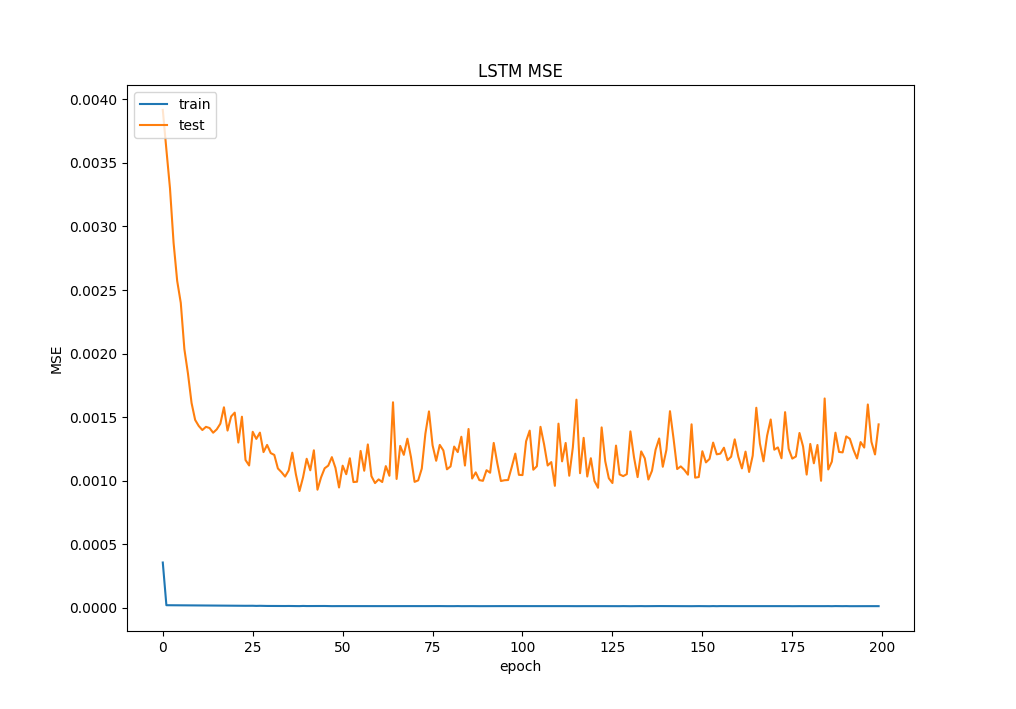

In [23]:
%matplotlib notebook

# summarize history for accuracy
plt.plot(model_history.history['mean_squared_error'])
plt.plot(model_history.history['val_mean_squared_error'])
plt.title('LSTM MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<IPython.core.display.Javascript object>


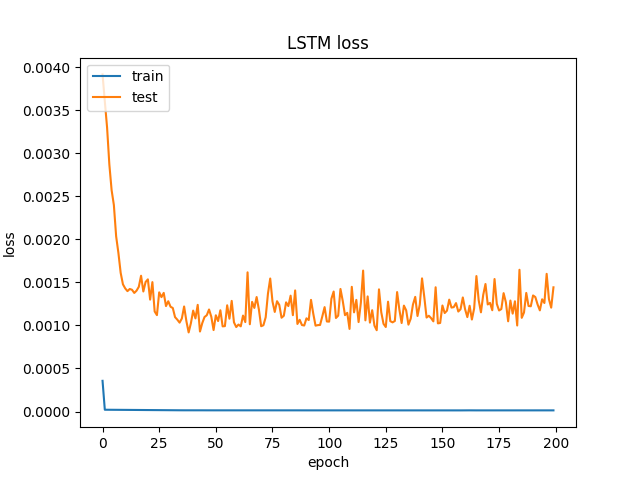

In [24]:
%matplotlib notebook

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [26]:
# Shift train predictions for plotting
trainPredictPlot = numpy.empty_like(close_dataset_norm)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [27]:
# Shift test predictions for plotting
testPredictPlot = numpy.empty_like(close_dataset_norm)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(close_dataset_norm)-1, :] = testPredict

<IPython.core.display.Javascript object>


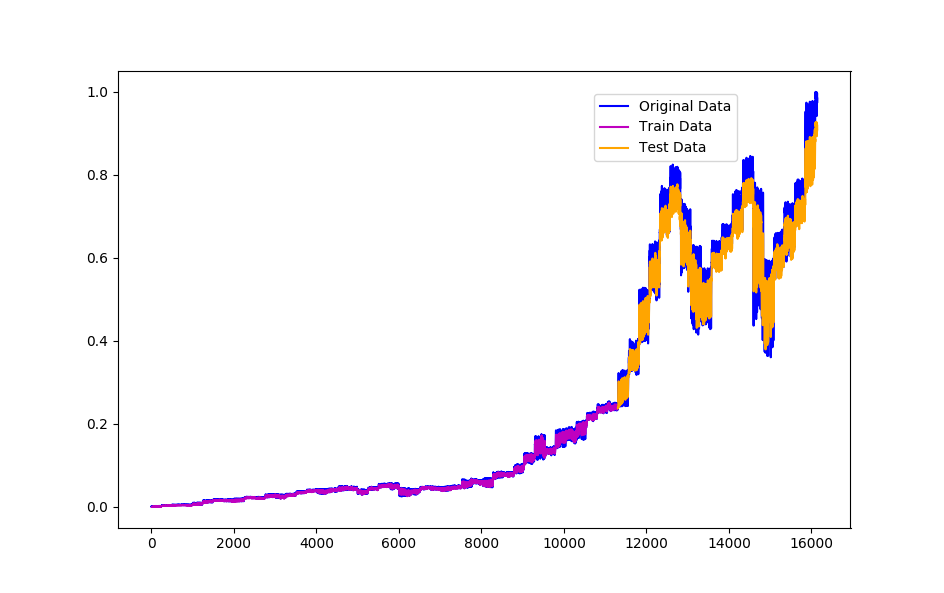

In [59]:
# Plot baseline and predictions
%matplotlib notebook
plt.plot(close_dataset_norm, color='b', label='Original Data')
plt.plot(trainPredictPlot, color='m', label='Train Data')
plt.plot(testPredictPlot, color='orange', label='Test Data')
plt.legend(bbox_to_anchor=(0.65, 0.95), loc=2, borderaxespad=0.)
plt.show()

In [29]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               71168     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 71,297
Trainable params: 71,297
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
scores = model.evaluate(testX, testY, verbose=0)
lstm_mse = scores[2]

print("%s: %.4f" % (model.metrics_names[0], scores[0]))
print("%s: %.4f" % (model.metrics_names[1], scores[1]))
print("%s: %.4f" % (model.metrics_names[2], scores[2]))
print("%s: %.4f" % (model.metrics_names[3], scores[3]))

loss: 0.0014
mean_absolute_error: 0.0292
mean_squared_error: 0.0014
mean_absolute_percentage_error: 4.5868


In [31]:
from sklearn.metrics import mean_squared_error
print("MSE : %.4f" %(mean_squared_error(testY, testPredict)))

MSE : 0.0014


In [47]:
index_x = [x for x in range(len(close_dataset_norm))]


# Scale down the values
sc = MinMaxScaler(feature_range=(0, 1))
# index_x_lin = sc.fit_transform(index_x)
close_dataset_norm_lin = sc.fit_transform(close_dataset_norm)

# Split the datasets
index_x_lin = numpy.reshape(index_x, (1,len(close_dataset_norm_lin))).T
X_train, X_test, y_train, y_test = train_test_split(index_x_lin, close_dataset_norm_lin, test_size=0.3)

# Print the shape of data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(11298, 1) (11298, 1)
(4843, 1) (4843, 1)


In [48]:
# Linear Regression

inputs = Input(shape=(1,))
preds = Dense(1,activation='linear')(inputs)

lin_model = Model(inputs=inputs,outputs=preds)
sgd= optimizers.SGD(lr=1e-8)
lin_model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mae','mse','mape'])
lin_model.fit(X_train, y_train, epochs=17, batch_size=100, verbose=0, validation_data=(X_test,y_test))

lin_prediction = lin_model.predict(X_test)

<IPython.core.display.Javascript object>


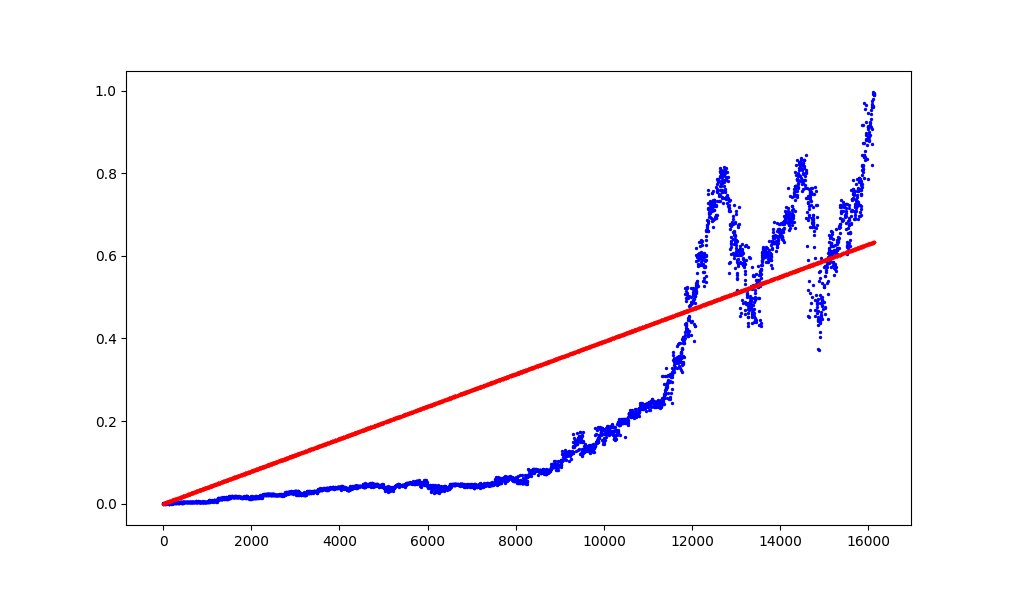

In [49]:
%matplotlib notebook
plt.scatter(X_test, y_test,  color='blue', s=2)
plt.scatter(X_test, lin_prediction, color='red', s=2)
plt.show()

In [50]:
scores = lin_model.evaluate(X_test, y_test, verbose=0)
lin_mse = scores[2]

print("%s: %.4f" % (lin_model.metrics_names[0], scores[0]))
print("%s: %.4f" % (lin_model.metrics_names[1], scores[1]))
print("%s: %.4f" % (lin_model.metrics_names[2], scores[2]))
print("%s: %.4f" % (lin_model.metrics_names[3], scores[3]))

loss: 0.0284
mean_absolute_error: 0.1469
mean_squared_error: 0.0284
mean_absolute_percentage_error: 259.2369


In [51]:
# Scale down the values
sc = MinMaxScaler(feature_range=(0, 1))
index_x = sc.fit_transform(index_x)
close_dataset_norm = sc.fit_transform(close_dataset_norm)

# Split the datasets
index_x = numpy.reshape(index_x, (1,len(close_dataset_norm))).T
X_train, X_test, y_train, y_test = train_test_split(index_x, close_dataset_norm, test_size=0.3)

# Print the shape of data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(11298, 1) (11298, 1)
(4843, 1) (4843, 1)


/Users/user/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/user/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [52]:
# SVM Model
from sklearn.svm import SVR

svr_model = SVR(kernel='rbf', C=1e3)
svr_model.fit(X_train, y_train)
svr_prediction = svr_model.predict(X_test)

/Users/user/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<IPython.core.display.Javascript object>


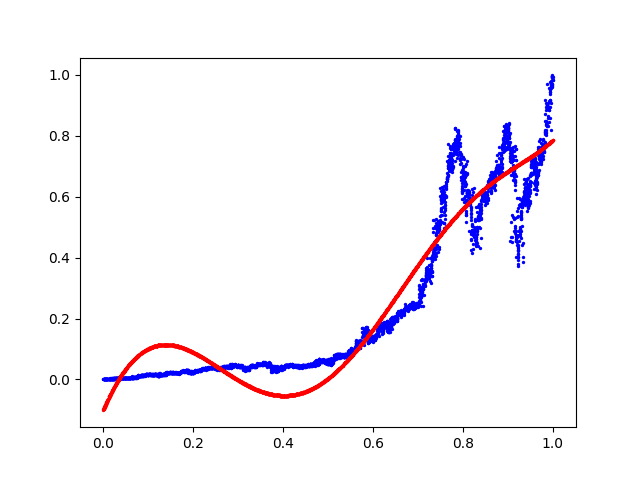

In [53]:
%matplotlib notebook
plt.scatter(X_test, y_test,  color='blue', s=2)
plt.scatter(X_test, svr_prediction, color='red', s=2)
plt.show()

In [54]:
from sklearn.metrics import mean_squared_error

svm_mse = mean_squared_error(y_test, svr_prediction)
print("MSE : %.4f" %(svm_mse))

MSE : 0.0074


In [55]:
from sklearn.ensemble import GradientBoostingRegressor

gbt_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='ls')
gbt_model.fit(X_train, y_train)
gbt_prediction = gbt_model.predict(X_test)

/Users/user/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<IPython.core.display.Javascript object>


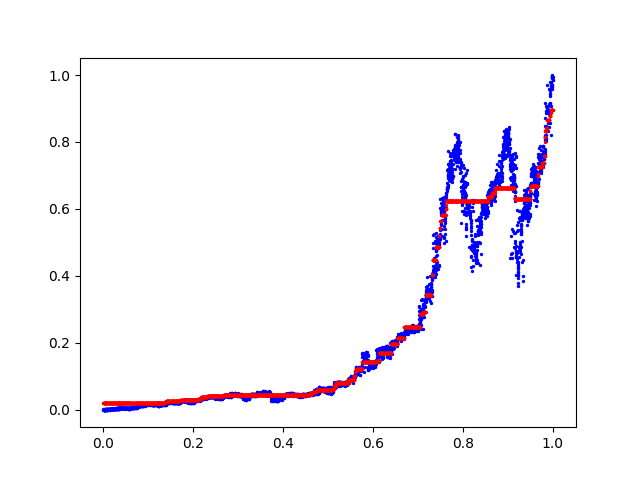

In [56]:
%matplotlib notebook
plt.scatter(X_test, y_test,  color='blue', s=2)
plt.scatter(X_test, gbt_prediction, color='red', s=2)
plt.show()

In [57]:
gbt_mse = mean_squared_error(y_test, gbt_prediction)
print("MSE : %.4f" %(gbt_mse))

MSE : 0.0019


In [58]:
print("MSE - Mean Square Error, the lower the better")
print("=============================================")
print("LSTM MSE : %.5f" %(lstm_mse))
print("Gradient Boosted MSE : %.5f" %(gbt_mse))
print("SVM MSE : %.5f" %(svm_mse))
print("Linear Regression MSE : %.5f" %(lin_mse))

MSE - Mean Square Error, the lower the better
LSTM MSE : 0.00144
Gradient Boosted MSE : 0.00193
SVM MSE : 0.00740
Linear Regression MSE : 0.02836
